In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import norm, solve
from scipy.optimize import Bounds, minimize

%matplotlib inline
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 15})

In [3]:
data_file = open('colombia.json',)
json_data = json.load(data_file)

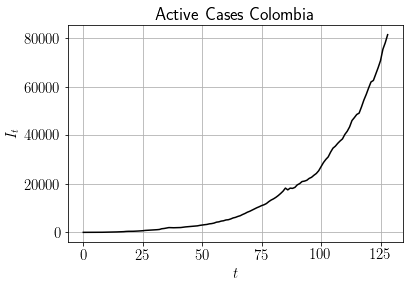

In [4]:
# Time series for Colombia
active_cases_co = json_data['co']['It']
plt.plot(active_cases_co, 'k')
plt.title('Active Cases Colombia')
plt.xlabel('$t$')
plt.ylabel('$I_t$')
plt.grid()
plt.show()

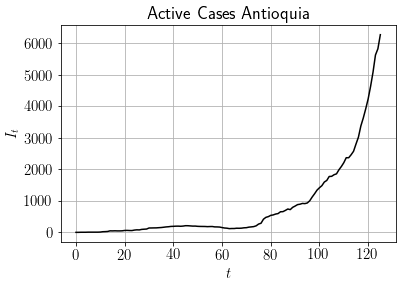

In [5]:
active_cases_an = json_data['co_05']['It']
plt.plot(active_cases_an, 'k')
plt.title('Active Cases Antioquia')
plt.xlabel('$t$')
plt.ylabel('$I_t$')
plt.grid()
plt.show()

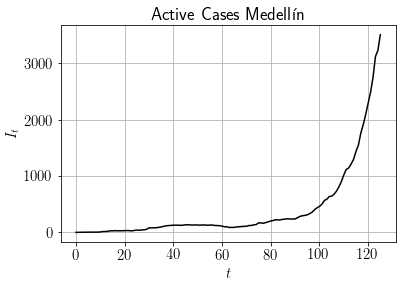

In [6]:
active_cases_me = json_data['co_05001']['It']
plt.plot(active_cases_me, 'k')
plt.title('Active Cases Medellín')
plt.xlabel('$t$')
plt.ylabel('$I_t$')
plt.grid()
plt.show()

# Estimate $R$ - ARMA LS

For data $\{I_{-2h},\ldots,I_{-1},I_{0},\ldots,I_t,I_{t+1}\}$

In [7]:
# time_series : 1D - np array (t+2,)
# h1          : int

def list2col(lst):
    return np.array(lst[::-1]).reshape((len(lst), 1))

def estimate_r(time_series, h1):
    if 2*h1 >= len(time_series) - 1:
        return None, None
    
    T = len(time_series) - 2*h1 - 2
    x = lambda t: list2col(time_series[(t + h1):(t + 2*h1 + 1)])
    v = lambda t: x(t - h1)
    
    V = np.zeros((h1 + 1, h1 + 1))
    Z = np.zeros((h1 + 1, h1 + 1))
    for s in range(T + 1):
        V += np.matmul(v(s), np.transpose(x(s+1)))
        Z += np.matmul(x(s), np.transpose(v(s)))
    
    A = np.matmul(np.transpose(V), np.linalg.inv(Z))
    
    betas = A[0, :]
    R = betas.sum()
    return R, A

# Estimate $R$ - AR Constrained LS

In [16]:
def estimate_r_opt(time_series, h, show=False):
    if 2*h >= len(time_series) - 1:
        return R
    
    T = len(time_series) - 2*h - 2
    x = lambda t: list2col(time_series[(t + h):(t + 2*h + 1)])
    
    A = []
    for s in range(h + 1):
        A.append(x(T-s))
    A = np.hstack(tuple(A))
    def of(R):
        aux = np.matmul(A, R.reshape((R.size, 1)))
        return np.power(norm(x(T+1) - aux), 2)
    
    init = np.zeros(h+1)
    bnds = Bounds([0 for s in range(h+1)], [np.inf for s in range(h+1)])
    sol = minimize(of, init, bounds=bnds)
    if show:
        print(sol)
    return sol.x.sum()

In [17]:
print(estimate_r_opt(active_cases_me, 14, show=True))

      fun: 49407.38763967281
 hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>
      jac: array([205475.25491565, 207876.88772543, 184835.79478925, 173496.5662763 ,
       157864.22372912, 136260.51004394, 137421.25447607, 118211.72520285,
       113131.64868625, 106086.01223794,  93273.36301794,  80829.78165476,
        92128.3288335 , 104738.01157787,  90727.98857233])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 368
      nit: 10
   status: 0
  success: True
        x: array([0.46769486, 0.16120168, 0.13827136, 0.07564913, 0.08522358,
       0.17282157, 0.06283099, 0.09583648, 0.02354528, 0.        ,
       0.00371399, 0.07148289, 0.        , 0.        , 0.        ])
1.3582718096452686


In [18]:
print(estimate_r_opt(active_cases_co, 14, show=True))

      fun: 6423272.984126372
 hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>
      jac: array([17066440.35875797, 18684056.86691403, 22104178.83470654,
       21953386.34774089, 15054922.45778441, 13941982.10909963,
       12911328.39396596, 14790739.39844966, 20774928.48038673,
       22179441.15400314, 21352120.67514658, 20024766.6798532 ,
       11278599.87318516, 12293460.49949527, 10533686.16849184])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 800
      nit: 20
   status: 0
  success: True
        x: array([0.36621144, 0.        , 0.        , 0.        , 0.03670478,
       0.25860999, 0.32509863, 0.08541962, 0.        , 0.        ,
       0.        , 0.        , 0.07547012, 0.04684093, 0.04691303])
1.2412685316999863


## Dynamics of $R$ w.r.t $h$

In [63]:
def analyze_r(time_series, h0=2, title=''):
    Rsh = []
    Rst = []
    index = -1
    delta_h = 0
    first = False
    second = False
    while True:
        if len(time_series[:index]) < 2*h0 + 2:
            first = True
        if len(time_series) < 2*(h0 + delta_h) + 2:
            second = True
        if first or second:
            break
        if not first:
            Rst.append(estimate_r_opt(time_series[:index], h0))
            index -= 1
        if not second:
            Rsh.append(estimate_r_opt(time_series, h0 + delta_h))
            delta_h += 1
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 5])
    ax1.plot(Rsh, 'k')
    ax1.set_xlabel('$h$')
    ax1.set_ylabel('$R_0$')
    
    ax2.plot(Rst, 'k')
    ax2.set_xlabel('$t^*$')
    ax2.set_ylabel('$R_0$')
    fig.suptitle(title)
    plt.show()
    
    return Rsh, Rst

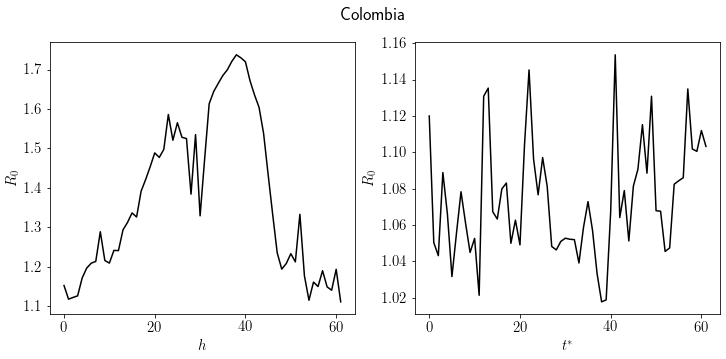

In [66]:
_, _ = analyze_r(active_cases_co, title='Colombia')

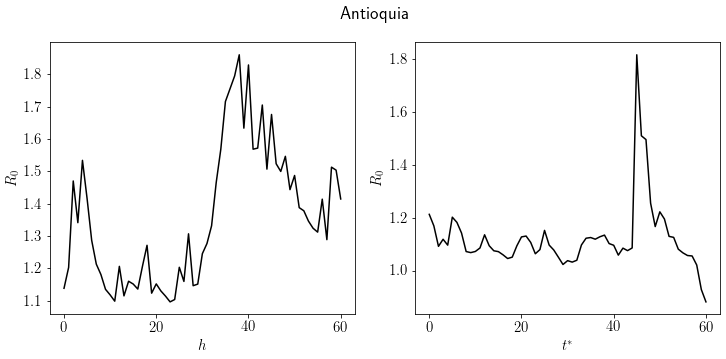

In [67]:
_, _ = analyze_r(active_cases_an, title='Antioquia')

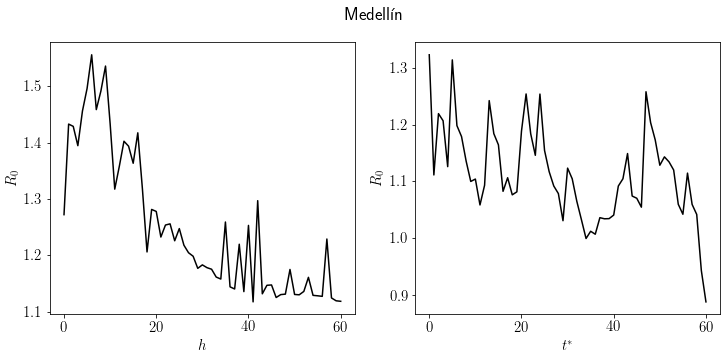

In [68]:
_, _ = analyze_r(active_cases_me, title='Medellín')

In [69]:
san_carlos = json_data['co_05649']['It']

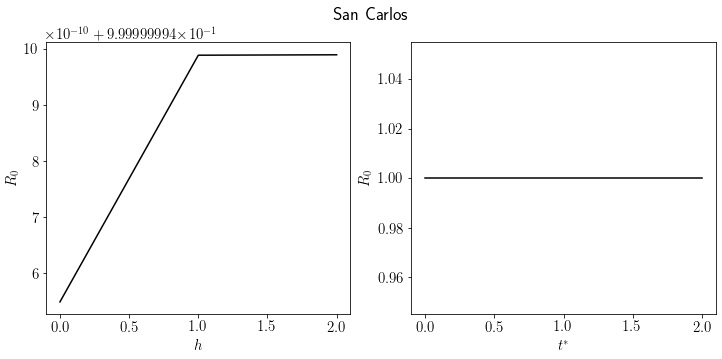

In [71]:
_, _ = analyze_r(san_carlos, title='San Carlos')